In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Data

In [2]:
df=pd.read_csv('household_power_consumption.txt', delimiter=';')

In [3]:
print('Number of rows and columns:', df.shape)

Number of rows and columns: (2075259, 9)


In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [5]:
print("Counting NA values per recognized columns with NA:")
print("Date NA Valus:"+ str(df.Date.isna().sum()))
print("Time NA Valus:"+ str(df.Time.isna().sum()))
print("Global_active_power NA Valus:"+str(df.Global_active_power.isna().sum()))
print("Global_reactive_power NA Valus:"+str(df.Global_reactive_power.isna().sum()))
print("Voltage NA Valus:"+str(df.Voltage.isna().sum()))
print("Global_intensity NA Valus:"+str(df.Global_intensity.isna().sum()))
print("Sub_metering_1 NA Valus:"+str(df.Sub_metering_1.isna().sum()))
print("Sub_metering_2 NA Valus:"+str(df.Sub_metering_2.isna().sum()))
print("Sub_metering_3 NA Valus:"+str(df.Sub_metering_3.isna().sum()))

Counting NA values per recognized columns with NA:
Date NA Valus:0
Time NA Valus:0
Global_active_power NA Valus:0
Global_reactive_power NA Valus:0
Voltage NA Valus:0
Global_intensity NA Valus:0
Sub_metering_1 NA Valus:0
Sub_metering_2 NA Valus:0
Sub_metering_3 NA Valus:25979


In [6]:
#Removing columns with huge amount of NA values
df.dropna()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,26/11/2010,20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,26/11/2010,21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,26/11/2010,21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000


In [7]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]

In [8]:
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

(2049280, 7)
2006-12-16 17:24:00
2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
2049275,2010-12-11 23:55:00,0.6900,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.6880,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.6880,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.6880,2010,4,12,11,0
2049279,2010-12-11 23:59:00,0.6880,2010,4,12,11,0


In [9]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


# Splitting the Data to Train and Test

In [10]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [12]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [13]:
X_train.shape

(1639393, 30)

In [14]:
Y_train.shape

(1639393,)

In [15]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building the Model

In [16]:
X_train.shape

(1639393, 1, 30)

In [17]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 76s 47us/step - loss: 7.4051e-04 - val_loss: 4.3697e-04
Epoch 2/20
1639393/1639393 [==============================] - 78s 48us/step - loss: 6.3495e-04 - val_loss: 4.3182e-04
Epoch 3/20
1639393/1639393 [==============================] - 72s 44us/step - loss: 6.2821e-04 - val_loss: 4.3994e-04
Epoch 4/20
1639393/1639393 [==============================] - 73s 44us/step - loss: 6.2582e-04 - val_loss: 4.2058e-04
Epoch 5/20
1639393/1639393 [==============================] - 80s 49us/step - loss: 6.2383e-04 - val_loss: 4.2361e-04
Epoch 6/20
1639393/1639393 [==============================] - 77s 47us/step - loss: 6.2203e-04 - val_loss: 4.1503e-04
Epoch 7/20
1639393/1639393 [==============================] - 74s 45us/step - loss: 6.2239e-04 - val_loss: 4.1045e-04
Epoch 8/20
1639393/1639393 [==============================] - 77s 47us/step - loss: 6.2142e-04 - val_loss: 4.1809e-04
Epo

# Evaluating the Model

In [18]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.10526040658969985
Train Root Mean Squared Error: 0.26760829136075404
Test Mean Absolute Error: 0.09105188577286794
Test Root Mean Squared Error: 0.22113706779294176


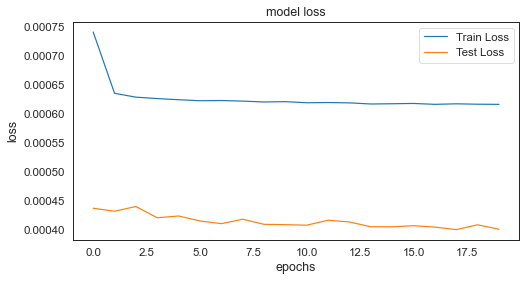

In [19]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# Visualizing the Results

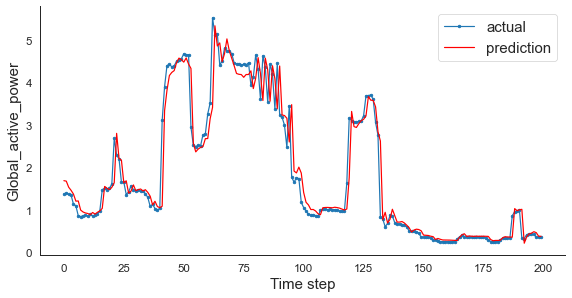

In [20]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();